In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pets-facial-expression-dataset/Other/aug-88-54.jpg
/kaggle/input/pets-facial-expression-dataset/Other/45.jpg
/kaggle/input/pets-facial-expression-dataset/Other/56.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-141-02.jpg
/kaggle/input/pets-facial-expression-dataset/Other/20.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-37-49.jpg
/kaggle/input/pets-facial-expression-dataset/Other/58.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-168-37.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-80-43.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-183-55.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-114-30.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-152-19.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-180-52.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-195-12.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-123-39.jpg
/kaggle/input/pets-facial-expression-dataset/

In [32]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

def load_pets_data(loading_method):
    if loading_method == 'kaggle':
        data_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder/train'
    elif loading_method == 'direct':
        data_path = 'pets/'
    classes = {'Other':0, 'Sad':1, 'happy':2,'Angry':3}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [33]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_pets_data('kaggle')

100%|██████████| 250/250 [00:00<00:00, 288.71it/s]


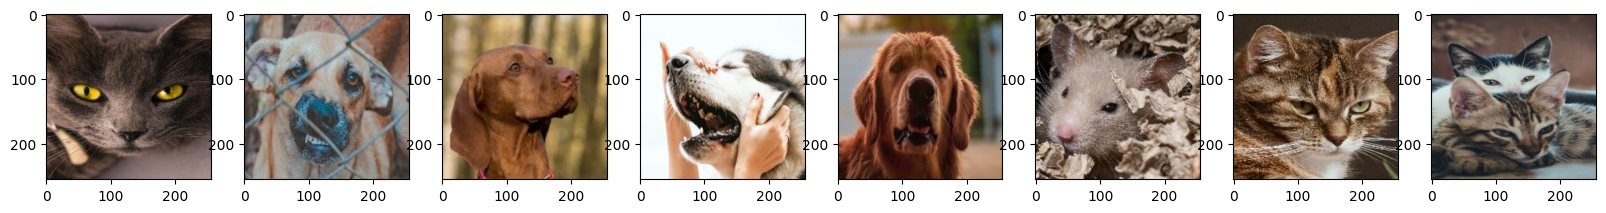

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])

In [35]:
from tensorflow.keras.applications.convnext import ConvNeXtSmall

def load_model():

    model = ConvNeXtSmall(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

    return model

In [36]:
def set_nontrainable_layers(model):

    model.trainable = False

    return model

In [37]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)

    model = models.Sequential([
        layers.Input(shape=X_train[0].shape),
        #Data Augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1),
        
        base_model,
        layers.Flatten(),
        layers.Dense(500, activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(500, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(500, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model

In [38]:
from tensorflow.keras import optimizers

def build_model():
    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [39]:
model = build_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_4            │ (None, 256, 256, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 8, 8, 768)      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 500)            │    24,576,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │         2,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,534,192 (284.33 MB)

 Trainable params: 25,079,504 (95.67 MB)

 Non-trainable params: 49,454,688 (188.65 MB)

In [40]:
from tensorflow.keras.applications.convnext import preprocess_input

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = build_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              #min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=65,
                    batch_size=32,
                    callbacks=[es, reduce_lr])

Epoch 1/65
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3527 - loss: 3.0960 - val_accuracy: 0.4900 - val_loss: 1.3216 - learning_rate: 0.0010
Epoch 2/65
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4758 - loss: 1.5524 - val_accuracy: 0.4950 - val_loss: 1.1439 - learning_rate: 0.0010
Epoch 3/65
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5479 - loss: 1.2126 - val_accuracy: 0.6050 - val_loss: 1.1422 - learning_rate: 0.0010
Epoch 4/65
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7107 - loss: 0.8547 - val_accuracy: 0.5900 - val_loss: 1.0126 - learning_rate: 0.0010
Epoch 5/65
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7024 - loss: 0.8019 - val_accuracy: 0.6150 - val_loss: 1.0228 - learning_rate: 0.0010
Epoch 6/65
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7395 - loss: 0.6940 - val_accuracy: 0.6800 - val_loss: 1.0290 - learning_rate: 0.0010
Epoch 7/65
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7990 - loss: 0.5425 - val_accuracy: 

In [42]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

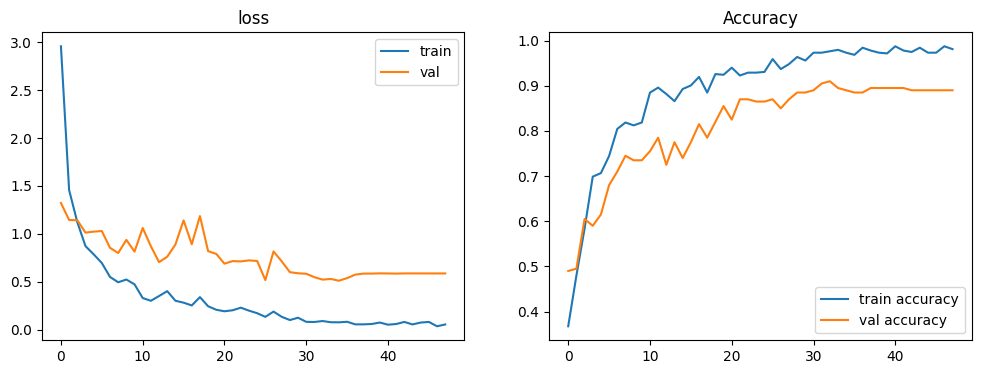

In [43]:
plot_history(history)

In [44]:
res = model.evaluate(X_test, y_test)

test_accuracy = res[-1]

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9102 - loss: 0.3748  
test_accuracy = 89.0 %
Chance level: 25.0%
